<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Predicting shots made per game by Kobe Bryant

_Authors: Kiefer Katovich (SF)_

---

In this lab you'll be using regularized regression penalties Ridge, Lasso, and Elastic Net to try and predict how many shots Kobe Bryant made per game in his career.

The Kobe shots dataset has hundreds of columns representing different characteristics of each basketball game. Fitting an ordinary linear regression using every predictor would dramatically overfit the model considering the limited number of observations (games) we have available. Furthermore, many of the predictors have significant multicollinearity. 

**Warning:** Some of these calculations are computationally expensive and may take a while to execute.  It may be worth while to only use a portion of the data to perform these calculations, especially if you have experienced kernel issues in the past.

---

### 1. Load packages and data

In [1]:
import numpy as np
import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [13]:
kobe = pd.read_csv('./datasets/kobe_superwide_games.csv')

---

### 2. Examine the data

- How many columns are there?
- Examine what the observations (rows) and columns represent.
- Why is this data that regularization might be particularly useful for?

In [14]:
# A:
kobe.shape

(1558, 645)

In [15]:
kobe.head()

,SHOTS_MADE,AWAY_GAME,SEASON_OPPONENT:atl:1996-97,SEASON_OPPONENT:atl:1997-98,SEASON_OPPONENT:atl:1999-00,SEASON_OPPONENT:atl:2000-01,SEASON_OPPONENT:atl:2001-02,SEASON_OPPONENT:atl:2002-03,SEASON_OPPONENT:atl:2003-04,SEASON_OPPONENT:atl:2004-05,...,ACTION_TYPE:tip_layup_shot,ACTION_TYPE:tip_shot,ACTION_TYPE:turnaround_bank_shot,ACTION_TYPE:turnaround_fadeaway_bank_jump_shot,ACTION_TYPE:turnaround_fadeaway_shot,ACTION_TYPE:turnaround_finger_roll_shot,ACTION_TYPE:turnaround_hook_shot,ACTION_TYPE:turnaround_jump_shot,SEASON_GAME_NUMBER,CAREER_GAME_NUMBER
0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
2,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
3,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
4,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5


---

### 3. Make predictor and target variables. Standardize the predictors.

Why is normalization necessary for regularized regressions?

Use the `sklearn.preprocessing` class `StandardScaler` to standardize the predictors.

In [16]:
kobe.columns[kobe.isnull().sum()>0]

Index([], dtype='object')

In [41]:
from sklearn.preprocessing import StandardScaler

y = kobe['SHOTS_MADE'].values
x = kobe.iloc[:,1:]

ss = StandardScaler()

xs = pd.DataFrame(ss.fit_transform(x),columns=x.columns)

In [42]:
# A:
def top_coefs(columns, coefficients, n=25):
    columns = columns[1:]
    coefs = [(columns[i], coef) for i, coef in enumerate(coefficients)]
    return list(sorted(coefs, key=lambda x: abs(x[1]), reverse=True))[:n]

In [43]:
lr = LinearRegression()
lr.fit(xs, y)
coef_lst = top_coefs(kobe.columns, lr.coef_)
coef_lst

[('SEASON:1999-00', 50113986998063.0),
 ('SEASON:2001-02', -45162810444264.852),
 ('SEASON:2009-10', -32695709200476.137),
 ('SEASON:1996-97', 26890084501837.836),
 ('CAREER_GAME_NUMBER', 26516187347958.273),
 ('SEASON:2000-01', 25997850958470.168),
 ('SEASON:2014-15', -23981231059531.848),
 ('SHOT_ZONE_RANGE:24+_ft.', 23754781984398.422),
 ('SEASON:1997-98', 22812548322272.918),
 ('SEASON:2015-16', -19468714477523.945),
 ('SEASON_OPPONENT:por:1999-00', -18081506139758.012),
 ('SEASON_OPPONENT:sac:1999-00', -17159162559744.215),
 ('SHOT_ZONE_AREA:center(c)', -16369642165859.068),
 ('SEASON_OPPONENT:ind:1999-00', -15142725297177.117),
 ('SEASON_OPPONENT:phx:1999-00', -15142725297177.014),
 ('SEASON_OPPONENT:sac:2001-02', 13870783331483.98),
 ('SEASON_OPPONENT:sas:2001-02', 12554703253381.301),
 ('SHOT_ZONE_BASIC:above_the_break_3', -12068191251023.025),
 ('SEASON_OPPONENT:gsw:1999-00', -11457889455468.91),
 ('SEASON_OPPONENT:min:1999-00', -11457889455468.871),
 ('SEASON_OPPONENT:sas:199

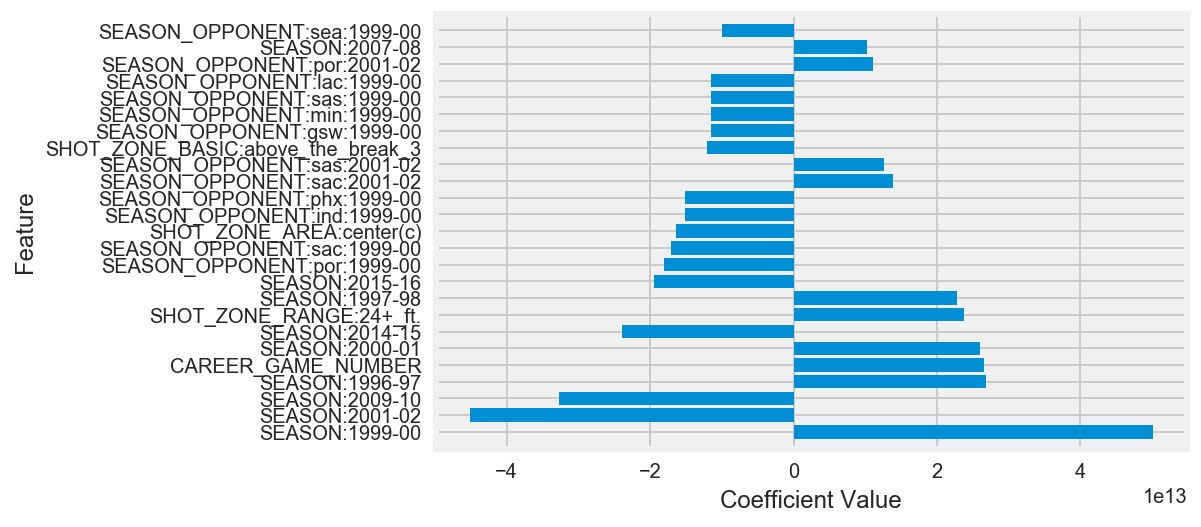

In [44]:
def plot_coefficients(top_coef_lst, n_features, feature_names):
    plt.barh(range(n_features), [item[1] for item in top_coef_lst], align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_coefficients(coef_lst, len(coef_lst), [item[0] for item in coef_lst])

In [45]:
from sklearn.cross_validation import train_test_split

In [49]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.33)

In [47]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X_train_ss = pd.DataFrame(ss.fit_transform(X_train),columns=x.columns)

---

### 4. Build a linear regression predicting `SHOTS_MADE` from the rest of the columns.

Cross-validate the $R^2$ of an ordinary linear regression model with 10 cross-validation folds.

How does it perform?

In [ ]:
# A:

---

### 5. Find an optimal value for Ridge regression alpha using `RidgeCV`.

[Go to the documentation and read how RidgeCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

> *Hint: once the RidgeCV is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that Ridge performs best searching alphas through logarithmic space (`np.logspace`). This may take awhile to fit!


In [50]:
print(lr.score(X_train,y_train))
print(lr.score(X_test,y_test))

-4.85568782779e+31
-4.4895126647e+31


In [36]:
# A:
ridge=Ridge(alpha=0.1)

---

### 6. Cross-validate the Ridge regression $R^2$ with the optimal alpha.

Is it better than the Linear regression? If so, why might this be?

In [ ]:
# A:

---

### 7. Find an optimal value for Lasso regression alpha using `LassoCV`.

[Go to the documentation and read how LassoCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) It is very similar to `RidgeCV`.

> *Hint: again, once the `LassoCV` is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that Lasso, unlike Ridge, performs best searching for alpha through linear space (`np.linspace`). However, you can actually let the LassoCV decide itself what alphas to use by instead setting the keyword argument `n_alphas=` to however many alphas you want it to search over. It is recommended to let sklearn choose the range of alphas.

_**Tip:** If you find your CV taking a long time and you're not sure if its working set `verbose =1`._

In [ ]:
# A:

---

### 8. Cross-validate the Lasso $R^2$ with the optimal alpha.

Is it better than the Linear regression? Is it better than Ridge? What do the differences in results imply about the issues with the dataset?

In [ ]:
# A:

---

### 9. Look at the coefficients for variables in the Lasso.

1. Show the coefficient for variables, ordered from largest to smallest coefficient by absolute value.
2. What percent of the variables in the original dataset are "zeroed-out" by the lasso?
3. What are the most important predictors for how many shots Kobe made in a game?

> **Note:** if you only fit the Lasso within `cross_val_score`, you will have to refit it outside of that
function to pull out the coefficients.

In [ ]:
# A:

---

### 10. Find an optimal value for Elastic Net regression alpha using `ElasticNetCV`.

[Go to the documentation and read how LassoCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html).

Note here that you will be optimizing both the alpha parameter and the l1_ratio:
- `alpha`: strength of regularization
- `l1_ratio`: amount of ridge vs. lasso (0 = all ridge, 1 = all lasso)
    
Do not include 0 in the search for `l1_ratio`: it will not allow it and break!

You can use `n_alphas` for the alpha parameters instead of setting your own values: highly recommended!

Also - be careful setting too many l1_ratios over cross-validation folds in your search. It can take a very long time if you choose too many combinations and for the most part there are diminishing returns in this data.

In [ ]:
# A:

---

### 11. Cross-validate the ElasticNet $R^2$ with the optimal alpha and l1_ratio.

How does it compare to the Ridge and Lasso regularized regressions?

In [ ]:
# A:

---

### 12. [Bonus] Compare the residuals for the Ridge and Lasso visually.


In [ ]:
# A: Maybe a jointplot?